# Explaining Failures

In this assignment, you will experiment with _explaining failures_ – specifically, correlating _input features_ with behavior such as failures.
We start with our well-known `EXPR_GRAMMAR` and use it to detect features and failures.

## A Grammar for Expressions

Again, we use the [Fuzzingbook format for grammars](https://www.fuzzingbook.org/html/Grammars.html), in which grammars are represented as dictionaries from symbols to lists of expansion alternatives.

In [1]:
from fuzzingbook.Grammars import Grammar
from fuzzingbook.Grammars import is_valid_grammar, convert_ebnf_grammar, extend_grammar

In [2]:
from isla.solver import ISLaSolver

In [3]:
EXPR_GRAMMAR: Grammar = {
    "<start>":
        ["<expr>"],

    "<expr>":
        ["<term> + <expr>", "<term> - <expr>", "<term>"],

    "<term>":
        ["<factor> * <term>", "<factor> / <term>", "<factor>"],

    "<factor>":
        ["+<factor>",
         "-<factor>",
         "(<expr>)",
         "<integer>.<integer>",
         "<integer>"],

    "<integer>":
        ["<digit><integer>", "<digit>"],

    "<digit>":
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

In [4]:
assert is_valid_grammar(EXPR_GRAMMAR)

We can use this grammar to produce syntactically valid arithmetic expressions:

In [5]:
expr_solver = ISLaSolver(EXPR_GRAMMAR)
for _ in range(10):
    print(expr_solver.solve())

4.3 + 512 / -(7 / 6 - 0 / 9 * 1 * 1) * +8.3 / 7 * 4 / 6
(4 / 7 + 1) / (4) / 9 / 8 + 4 / (3 + 6 - 7)
+--(--(-9) * (4 * 7 + (4) + 4) + --(+(3)) - 6 + 0 / 7 + 7)
(2 * 6 + 0 - 5) * 4 - +1 * (2 - 2) / 8 / 6
(+-(0 - (1) * 7 / 3)) / ((1 * 3 + 8) + 9 - +1 / --0) - 5 * (-+939.491)
+2.9 * 0 / 501.19814 / --+--(6.05002)
+-8.8 / (1) * -+1 + -8 + 9 - 3 / 8 * 6 + 4 * 3 * 5
(+(8 / 9 - 1 - 7)) + ---06.30 / +4.39
8786.82 - +01.170 / 9.2 - +(7) + 1 * 9 - 0
+-6 * 0 / 5 * (-(1.7 * +(-1 / +4.9 * 5 * 1 * 2) + -4.2 + (6 + -5) / (4 * 3 + 4)))


## Explaining Failures

If we detect a failure, we can check whether there are specific _input features_ that correlate with failures. In this exercise, we will come up with a very simple, yet general kind of features, namely the presence or absence of individual language elements.

Our plan is as follows. First, we will introduce some _predicates_ that check for the presence (or absence) of symbols in a derivation tree, This derivation tree can come from _producing_ inputs (i.e., fuzz them), or from _parsing_ inputs. Then, we establish _correlations_ between the presence (or absence) of elements and failures.

### Checking Features

We start with _checking_ for individual symbols in a tree – say, the tree coming from parsing the expression `2 + 2`:

In [6]:
from fuzzingbook.GrammarFuzzer import display_tree

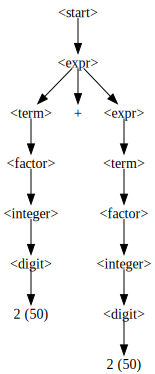

In [7]:
expr_solver = ISLaSolver(EXPR_GRAMMAR)
expr_tree = expr_solver.parse('2 + 2')
display_tree(expr_tree)

We define a function `has_element()` which checks if a particular element (a symbol or expansion from the grammar rules) occurs in the derivation tree.
For the above tree `expr_tree`, `has_element()` should return `True` for elements such as

* `'<digit>'` - a _nonterminal_ from `EXPR_GRAMMAR`
* `'2'` - a _terminal_ (and possible expansion) from `EXPR_GRAMMAR`
* `'<term> + <expr>'` – an _expansion_ from `EXPR_GRAMMAR`

as they occur in `expr_tree`; and `False` for queries such as

* `'7'` - does not occur in `expr_tree`
* `'<expr> + <term>'` - does not occur in `expr_tree` (and not in `EXPR_GRAMMAR`)

In [8]:
expr_tree.value

'<start>'

In [9]:
expr_tree.children[0].children[1].value

' + '

In [10]:
def has_element(tree, element) -> bool:
    """Return True iff `element` occurs in `tree`.
    `element` can any symbol or expansion from a grammar"""
    if element == tree.value:
        return True  # match nonterminal

    expanded_children = ''
    for c in tree.children:
        expanded_children += c.value
    if element == expanded_children:
        return True  # match expansion

    for c in tree.children:
        if has_element(c, element):
            return True

    return False

In [11]:
has_element(expr_tree, '<digit>')

True

In [12]:
has_element(expr_tree, '2')

True

In [13]:
has_element(expr_tree, '<term> + <expr>')

True

In [14]:
has_element(expr_tree, '7')

False

In [15]:
has_element(expr_tree, '<expr> + <term>')

False

Note that matching only goes one level deep. Hence, the following holds:

In [16]:
has_element(expr_tree, '2 + 2')

False

### Checking all Features

For a given grammar, let us now check which of its symbols and expansions actually are present in a derivation tree. We could do so by checking all elements of the grammar with `has_element()`, but we can actually derive the set from a derivation tree alone:

In [17]:
def all_elements(tree):
    """Returns the set of all elements (nonterminals or expansions) occurring in `tree`"""
    elements = {tree.value}

    expanded_children = ''
    for c in tree.children:
        expanded_children += c.value
    elements.add(expanded_children)

    for c in tree.children:
        elements |= all_elements(c)

    return elements

In [18]:
all_elements(expr_tree)

{'',
 ' + ',
 '2',
 '<digit>',
 '<expr>',
 '<factor>',
 '<integer>',
 '<start>',
 '<term>',
 '<term> + <expr>'}

In [19]:
for e in all_elements(expr_tree):
    assert has_element(expr_tree, e)

We can also easily extract all elements from a grammar:

In [20]:
def all_grammar_elements(grammar):
    elements = set(grammar.keys())
    for k in grammar.keys():
        elements |= set(grammar[k])
    return elements

In [21]:
all_grammar_elements(EXPR_GRAMMAR)

{'(<expr>)',
 '+<factor>',
 '-<factor>',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '<digit>',
 '<digit><integer>',
 '<expr>',
 '<factor>',
 '<factor> * <term>',
 '<factor> / <term>',
 '<integer>',
 '<integer>.<integer>',
 '<start>',
 '<term>',
 '<term> + <expr>',
 '<term> - <expr>'}

Note how `all_elements()` overapproximates over `all_grammar_elements()`: it also lists `' + '` as a terminal symbol, although this is not an explicit expansion in `EXPR_GRAMMAR`. We can remedy this by computing the intersection of both sets.

In [22]:
all_elements(expr_tree) & all_grammar_elements(EXPR_GRAMMAR)

{'2',
 '<digit>',
 '<expr>',
 '<factor>',
 '<integer>',
 '<start>',
 '<term>',
 '<term> + <expr>'}

### Relating Features and Failures

We now will determine a number of passing and failing inputs, and determine their common features.

In [23]:
SAMPLE_SIZE = 1000
labeled_inputs = {}

In [24]:
solver = ISLaSolver(EXPR_GRAMMAR, max_number_free_instantiations=SAMPLE_SIZE)
for i in range(SAMPLE_SIZE):
    random_expr = solver.solve()
    try:
        eval(str(random_expr))
    except Exception as exc:
        label = str(exc)
    else:
        label = 'pass'

    if label not in labeled_inputs:
        labeled_inputs[label] = []
    labeled_inputs[label].append(random_expr)

In [25]:
labeled_inputs.keys()

dict_keys(['pass', 'float division by zero', 'division by zero', 'leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 1)'])

In [26]:
for tree in labeled_inputs['division by zero'][:10]:
    print(tree)

(30) / 0 * 7 / 2 - -1 - 7 * 6 + 3 * 9 + 8
(-7 / 0 * 7) * ++7 / 1.2 + (8) + -+6 * -6 * 1
3 * 0 / (5 * 0) + 3 - 2 + 3 * 1 * 1 / 3
3499 + (6 * 3 / 0) / 78.9 - ((3 + 4) - 1) / 7
9955643 - (6 + 0 + 1) / +1 / 3 / 1 * 5 - ++(0 / 0 + 5) / +6.03
95.2 + +(7 + 4) * 2 / 0 - 2 / 9 - 9 + 1
++(8 / 0 - 6) / 7 + ++-+(8 + 6 / 2) * -+6 / +3 / 0.2
-((3 + 9 + 8 - 9) * -(6) + 9) / 0 / 01.0 + 61 / -1
(+(5) * 7 / 3 + 3 / 0 * 8 * 1) / --05.68 - 2663 / --96
673 * 5 * 4 / 0 - 2 / ++(0 - 9) / 9


Let us find out whether these have any common features:

In [27]:
def print_common_elements(labeled_inputs, grammar):
    for category in labeled_inputs.keys():
        common_elements = all_grammar_elements(grammar)
        for tree in labeled_inputs[category]:
            common_elements &= all_elements(tree)
        print(f'{category}: {common_elements}')

In [28]:
print_common_elements(labeled_inputs, EXPR_GRAMMAR)

pass: {'<term>', '<factor>', '<expr>', '<start>', '<integer>', '<digit>'}
float division by zero: {'<term>', '<factor> / <term>', '<factor>', '<expr>', '<start>', '<integer>', '<digit>'}
division by zero: {'<term>', '<factor> / <term>', '<factor>', '<expr>', '0', '<start>', '<integer>', '<digit>'}
leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 1): {'<term>', '<digit><integer>', '<factor>', '<expr>', '0', '<start>', '<integer>', '<digit>'}


This is pretty interesting already - but actually, we need not care about the elements that already occur in all passing expressions. Instead, we can focus on the _difference_. For this, we determine the elements common to all passing runs:

In [29]:
common_pass_elements = all_grammar_elements(EXPR_GRAMMAR)
for tree in labeled_inputs['pass']:
    common_pass_elements &= all_elements(tree)
common_pass_elements

{'<digit>', '<expr>', '<factor>', '<integer>', '<start>', '<term>'}

Let us remove these from our listing.

**Assignment 1.** Adapt `print_common_elements()`, above, into a new function `print_diff_elements()`, which skips common passing elements in the given `grammar`. Also skip the `pass` category.

In [30]:
def print_diff_elements(labeled_inputs, grammar):
    common_pass_elements = all_grammar_elements(grammar)
    ...  # <-- expand code here

Here is an example:

In [32]:
print_diff_elements(labeled_inputs, EXPR_GRAMMAR)

pass: set()
float division by zero: {'<factor> / <term>'}
division by zero: {'0', '<factor> / <term>'}
leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 1): {'0', '<digit><integer>'}


We now see the common elements across all failure categories: for divisions by zero, it is `<factor> / <term>`; for leading zeros, it is `0` and `<digit><integer>`. If the failure categories were not already self-explanatory, these common features would still give us important hints on how the failure comes to be.

But how about the digit `0` (zero)? Shouldn't it be listed in the "division by zero" category, too? No, because there are ways to generate a division by zero without the digit `0` - say, `1 / (1 - 1)`. Still, the presence of a zero digit still strongly correlates with failure. Let's see if we can extract these.

### The Ochiai Metric

The _Ochiai_ Metric (Ochiai 1957) first introduced in the biology domain (daSilvaMeyer, 2004) and later applied for fault localization by Abreu et al. (2009), can be used to determine the _suspiciousness_ of a feature – that is, how much it correlates with failures (and not with non-failures). It is defined as follows:

$$
\textit{suspiciousness}_\textit{ochiai} = \frac
{\textit{failed}(\textit{event})}
{\sqrt{
\bigl(\textit{failed}(\textit{event}) + \textit{not-in-failed}(\textit{event})\bigr)
\times
\bigl(\textit{failed}(\textit{event}) + \textit{passed}(\textit{event})\bigr)
}}
$$

where

* $\textit{failed}(\textit{event})$ is the number of times the event occurred in _failing_ runs
* $\textit{not-in-failed}(\textit{event})$ is the number of times the event did _not_ occur in failing runs
* $\textit{passed}(\textit{event})$ is the number of times the event occurred in _passing_ runs.

We can easily implement this formula:

In [33]:
import math

In [34]:
def suspiciousness(element, labeled_inputs, category):
    passed = 0
    for tree in labeled_inputs['pass']:
        if has_element(tree, element):
            passed += 1

    failed = 0
    not_in_failed = 0
    for tree in labeled_inputs[category]:
        if has_element(tree, element):
            failed += 1
        else:
            not_in_failed += 1

    try:
        return failed / math.sqrt((failed + not_in_failed) * (failed + passed))
    except ZeroDivisionError:
        return None

Let us check a few suspiciousness scores for the `division by zero` category. Here's a first score for division:

In [35]:
suspiciousness('<factor> / <term>', labeled_inputs, 'division by zero')

0.28927842707018586

Is this a lot? Or not much? Suspiciousness is a _relative_ measure – so let's compare it against others. For instance, division is more suspicious than addition...

In [36]:
suspiciousness('<term> + <expr>', labeled_inputs, 'division by zero')

0.27523648750864216

... or like the digit `9`, for instance:

In [37]:
suspiciousness('9', labeled_inputs, 'division by zero')

0.19834081894499206

The digit zero, however, has the highest suspiciousness.

In [42]:
suspiciousness('0', labeled_inputs, 'division by zero')

0.3290945898939588

**Assignment 2.** Implement a function `print_suspiciousness(labeled_inputs, grammar)` that takes as input 

* `labeled_inputs`: a mapping of failure categories (strings) to lists of derivation trees exposing this failure category - e.g. `labeled_inputs` as defined above.
* `grammar`: a grammar such as `EXPR_GRAMMAR`.

For each category and each grammar element, have `print_suspiciousness()` print out the element and its suspiciousness. Do not list the `pass` category and omit the elements common to all passing runs (as `common_pass_elements`), above.

**Bonus**: _Sort_ the output such that elements with the highest suspiciousness come first, and have an optional paremeter `n` limit the output to `n` most suspicious elements. Format the output nicely.

In [39]:
def print_suspiciousness(labeled_inputs, grammar):
    common_pass_elements = all_grammar_elements(EXPR_GRAMMAR)
    for tree in labeled_inputs['pass']:
        common_pass_elements &= all_elements(tree)

    for category in labeled_inputs.keys():
        if category == 'pass':
            continue
        ...  # <-- your code goes here

Here is a trial run of `print_suspiciousness()`, listing the five most suspicious elements:

In [60]:
print_suspiciousness(labeled_inputs, EXPR_GRAMMAR, n=5)

float division by zero
0                              0.37
<factor> / <term>              0.33
<factor> * <term>              0.31
<integer>.<integer>            0.3
<term> + <expr>                0.3

division by zero
0                              0.33
<factor> / <term>              0.29
<factor> * <term>              0.28
<term> - <expr>                0.28
(<expr>)                       0.28

leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 1)
0                              0.24
<digit><integer>               0.22
4                              0.21
-<factor>                      0.19
<factor> * <term>              0.19



We see that zeroes are now listed as most suspicious for all errors, even they do not occur in _all_ division by zero runs. Divisions, as expected, are the second most suspicious feature for division by zero errors.

There are many ways to expand this – have more features to check, visualize suspiciousness, use classifiers from machine learning to distinguish failing from non-failing features, or have a reinforcement loop that generates more inputs (using ISLa) to support a hypothesis. Try this yourself!